# How to scale Amplitudes in FFT calculated spectrum

In [108]:
# Copyright (C) 2020 Danny Schneider
##
## This program is free software; you can redistribute it and/or
## modify it under the terms of the GNU General Public
## License as published by the Free Software Foundation;
## either version 2, or (at your option) any later version.
##
## Octave is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied
## warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR
## PURPOSE.  See the GNU General Public License for more
## details.
##
## You should have received a copy of the GNU General Public
## License along with Octave; see the file COPYING.  If not,
## write to the Free Software Foundation, 59 Temple Place -
## Suite 330, Boston, MA 02111-1307, USA.

In [90]:
fig=1;

## public functions

In [ ]:
function result=my_normalize(data,newmax)
  newmax=abs(newmax);                   # Remove sign of newmax
  signal_min=abs(min(data));            # Find absolut minimum
  signal_max=abs(max(data));            # Find absolut maximum
  factor=max([signal_min,signal_max]);  # choose scaling factor 
  result=(data .* newmax) ./ factor;    # scale the data
endfunction

In [91]:
function res=get_mean(data)
  res=0;
  div=length(data);
  for(ii=1:1:length(data))
    res = res .+ (data(ii)./div);
  endfor
endfunction

In [92]:
function spectrum = tospectrum(timedomain_data)
  tmp = fft(timedomain_data);
  #(1,1:(length(timedomain_data)./2));
  noiseshift = -10*log(length(tmp));
  #noiseshift=0;
  spectrum = 20.*log(abs(tmp)) .+ noiseshift;
endfunction

Theoretical Noise Floor to best Signal

In [93]:
function res = snr_expected(bits)
  res = 6.022*bits+1.76;
endfunction

Calculate position of hamonics

In [94]:
function pos = harmonic_pos_calc(nos,fs,fsig,harmonic)
  f1pos = nos./(fs./2.0).*fsig;
  vpos = f1pos.*(1.+harmonic);
  mirror = floor(vpos/nos);
  even = mod(mirror,2.0);
  rest = mod(vpos,nos);
  if(even==0)
    pos=round(rest);
  else
    pos=round(nos-rest);
  endif
endfunction

Estimate Amplitude of hamonic

In [95]:
function res=harmonic_extract(data,pos,noiseval)
  lpos=pos;
  rpos=pos;
  if(pos>0)
    if(pos<length(data))
      while(data(lpos)>noiseval)
        --lpos;
        if(lpos==0)
          break;
        endif
      endwhile    
      while(data(rpos)>noiseval)
        ++rpos;
        if(rpos==length(data))
          break;
        endif
      endwhile
    endif
  endif
   
  res = 0;
  scale=rpos.-lpos.+1;
  for(ii=lpos:1:rpos)
    res += data(ii)./scale;
  endfor
endfunction

Basic Constants

In [96]:
fs      = 100; #Sampling Frequency
Ts      = 1./fs; #Sampling period
fsig    = 2;   #Signal Frequency
periods = 10;    #Number of Periods
amp     = 1.5;   #Signal Amplitude
20.*log10(amp)   #Signal Amplitude in dB

ans =  3.5218


## time discrete sine
__infinite__ amplitude resolution

mean =   -1.7432e-16


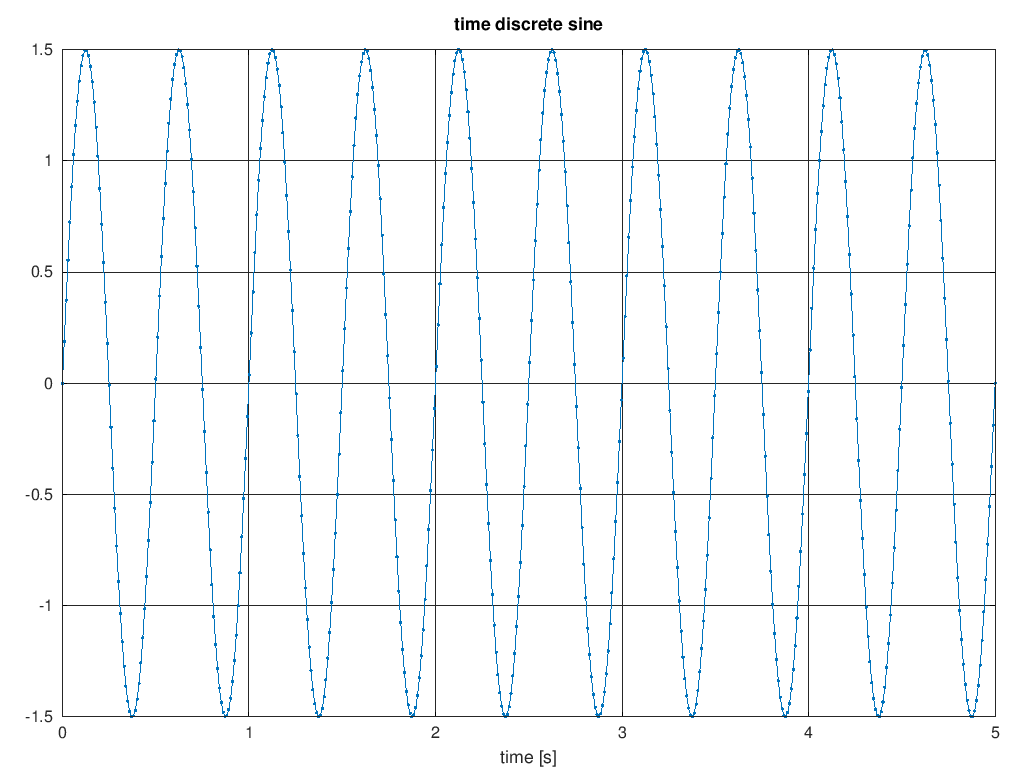

In [97]:
figure(fig++);
tend=periods./fsig;
nos = ceil(tend.*fs);
tend = nos./fs;
t=linspace(0,tend,nos);
y=amp.*sin(2.*pi().*t.*fsig);
mean=get_mean(y)
plot(t,y,"- .");
grid on;
title("time discrete sine");
xlabel("time [s]");

## sample Signal with a ideal ADC

In [98]:
range=2.*amp;
bits=5;
LSB=range./(2.^bits);
dy=round((y.+amp)./LSB);
SNR=snr_expected(bits)
mean=get_mean(dy)

SNR =  31.870
mean =  16.000


## time discrete sine
discrete amplitude resolution

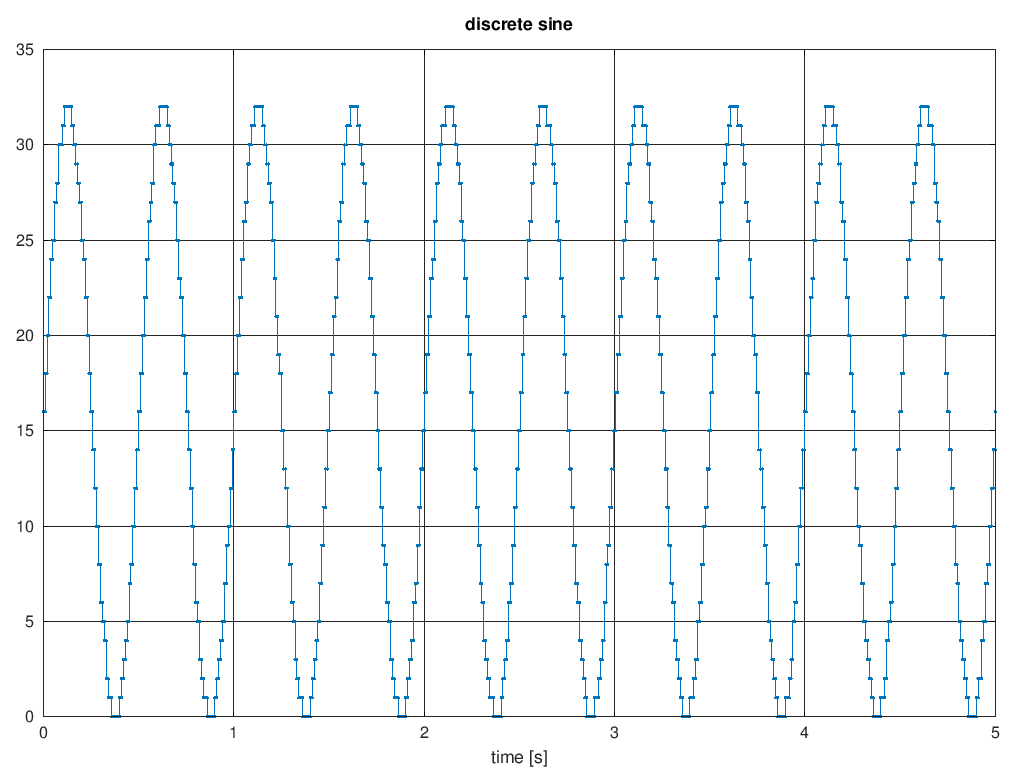

In [99]:
figure(fig++);
stairs(t,dy,"- .");
grid on;
title("discrete sine");
xlabel("time [s]");

## Zero Extend Signal-Length to power of 2

In [100]:
nos2=2^ceil(log2(nos));
znos=nos2.-nos;
ze=zeros(1,znos);
dy = [dy ze];

## spectrum

In [101]:
f=linspace(0,fs,nos)(1:1:(nos/2));
s=(2./nos).*LSB.*abs(fft(dy)(1:1:(nos/2)));
s(1)=0; #set DC to zero
s(2)=0;
s(3)=0;
max(s) #Get value of fundamental peak
lineresolution=fs./(2.*nos);

ans =  1.3651


Positions of Harmonics

In [102]:
hpos=zeros(1,5);
for ii=1:1:length(hpos)
  hpos(:,ii)=harmonic_pos_calc(nos,fs,fsig,ii.-1);
endfor
hpos

hpos =

    20    40    60    80   100



Extract Value / Amplitude of Harmonics

In [103]:
hamp=zeros(1,length(hpos));
for ii=1:1:length(hpos)
  hamp(:,ii)=harmonic_extract(s,hpos(:,ii),2.*LSB);
endfor
hamp

hamp =

   0.0636189   0.0068407   0.0159005   0.0057946   0.0089534



Plot of spectrum

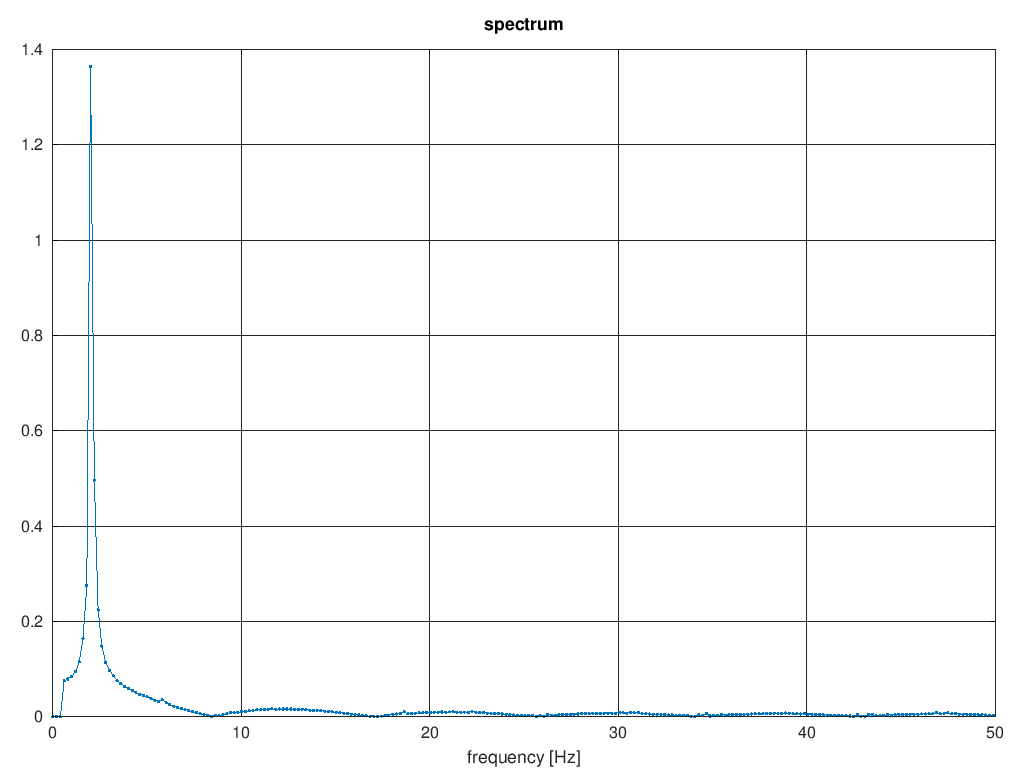

In [104]:
figure(fig++);
plot(f,s,"-d.");
grid on;
title("spectrum");
xlabel("frequency [Hz]");

## logarithmic scaled amplitude spectrum in dB

ans =  2.7030


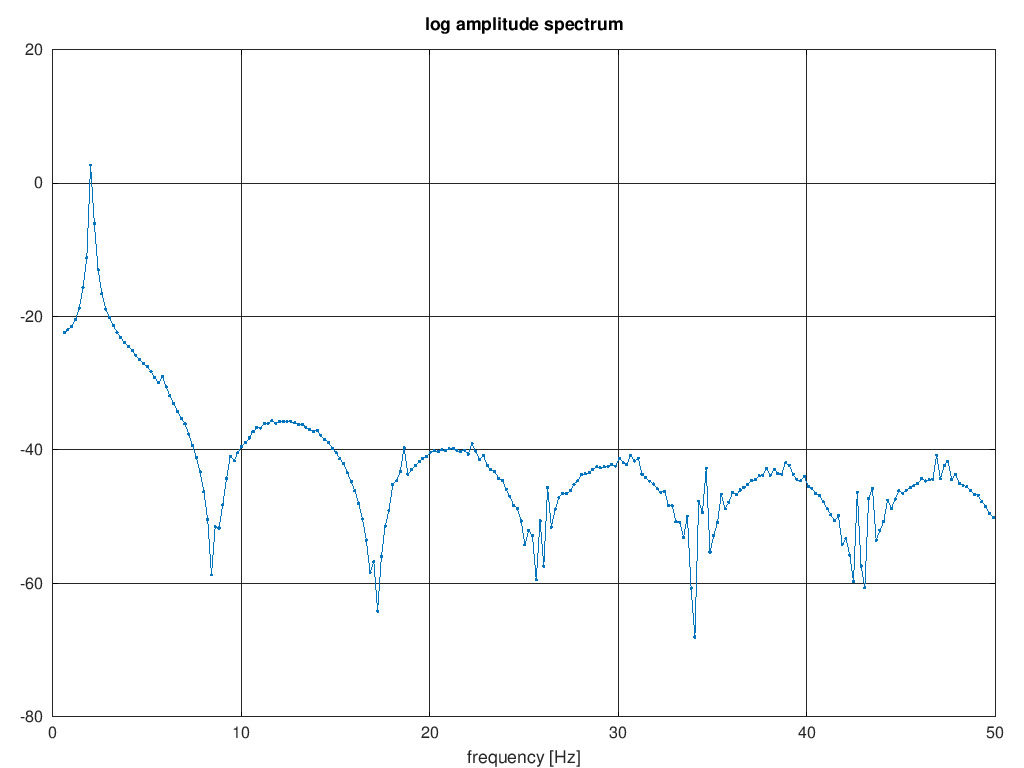

In [105]:
figure(fig++);
sl=20.*log10(s);
max(sl) #Get value of fundamental peak
plot(f,sl,"-d.");
grid on;
title("log amplitude spectrum");
xlabel("frequency [Hz]");

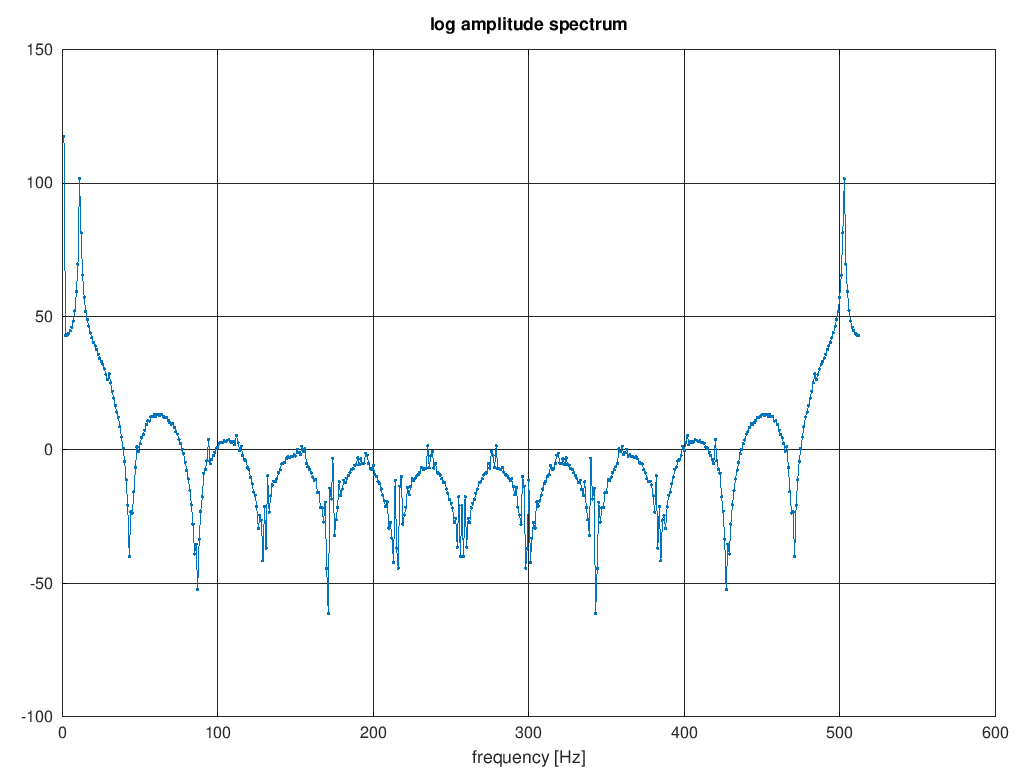

In [107]:
figure(fig++);
plot(tospectrum(dy),"-d.");
grid on;
title("log amplitude spectrum");
xlabel("frequency [Hz]");